### Instructions

Please be patient while waiting for the environment to load; it may take a few minutes. 
Once the notebook has finished loading, in the top bar, select `Kernel`--> `Restart Kernel and Run All Cells`. 
Once the notebook has finished running, you should see a plot with sliders appear at the bottom.

If you make any changes in a coding cell, rerun the notebook by `Run` > `Run Selected Cell and All Below`

Enjoy!

In [1]:
# Importing libraries and dependencies
import sys
sys.path.append('python/')
import load_galaxies as galdata
import components as comp                      # Functions for galaxy components.
import dataPython as dp

import numpy as np
import matplotlib.pyplot as plt                # Plotting
%matplotlib inline

import scipy.integrate as si                   # Integration
from ipywidgets import interactive, fixed, FloatSlider, HBox, Layout, Button, Label, Output, VBox
from IPython.display import display, clear_output
from IPython.display import Javascript

import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")              # Ignore warnings

# Introduction to Dark Matter

If luminous matter was the only matter in spiral galaxies, then the rotation curves would resemble that of planet-like, or Keplerian, motion. Since the rotation curves of some spiral galaxies are flat, we can infer that there is "missing" matter that is not interacting with light but affecting the velocity of stars and gas. We call this missing matter "dark matter." <br>
According to Newton's law of gravitation, gravitational force on an object is proportional to the mass interacting with it, and therefore the motion of matter in a galaxy is also proportional to this mass. 
Setting the gravitational force and the centripetal force equal, the rotational velocity can be computed in terms of mass ($M$) and distance ($r$) from the center. 

>__Newton's Law of Gravitation__: <br>
    \begin{equation}
    F_g = G \frac{Mm}{r^2}
    \end{equation}<br>
>__Centripetal Force__: <br>
    \begin{equation}
    F_c = \frac{mv^2}{r}
    \end{equation}<br>
>__Rotational velocity__: <br>
    \begin{equation}
    v = \sqrt{\frac{GM}{r}}
    \end{equation}<br>
    
Since visible matter can be measured through photometry, a theoretical rotation curve can be computed applying the above equations. <br>
However, as you will discover in the following exercises, this theoretical curve does not always agree with the measured velocities. 

## Interactive widget with variable Dark Matter component - Galaxy: NGC 5533

In the following activity, you can experiment adding or removing Dark Matter and investigating how the total velocity of stars and gases change in a galaxy. 

### Measured data points

In the code below, you will import the measured data points for the NGC 5533 galaxy. These are measured velocities of stars and gas in the galaxy as a function of radius. The data points were traced from Figure 4. in Noordermeer (2008). 

In [2]:
# Import measured velocity data
data = dp.getXYdata_wXYerr('data/NGC5533/noord-120kpc-datapoints.txt')
r_dat = np.asarray(data['xx'])              # radius
v_dat = np.asarray(data['yy'])              # velocity
v_err0 = np.asarray(data['ex'])             # error in radius
v_err1 = np.asarray(data['ey'])             # error in velocity

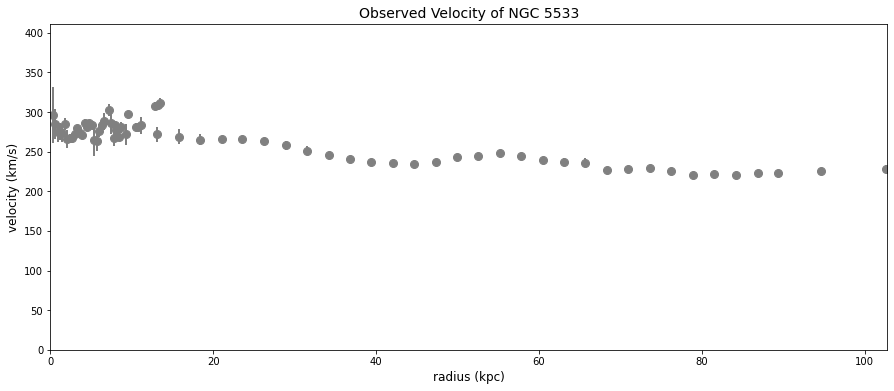

In [3]:
# Plot 
plt.figure(figsize=(15,6))                                               # size of the galaxy
plt.errorbar(r_dat,v_dat,yerr=v_err1, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2)  # plot datapoints with errorbars
plt.xlabel('radius (kpc)',size=12)                                       # label x-axis
plt.ylabel('velocity (km/s)',size=12)                                    # label y-axis
plt.title(str('Observed Velocity of NGC 5533'), size=14)                 # title of the plot
plt.xlim(0,np.max(r_dat)+0.2)                                            # range of the x-axis
plt.ylim(0,np.max(v_dat)+100)                                            # range of the y-axis
plt.show()                                                               # show the plot

### Galactic components

The components of a galaxy are categorized based on how stars and gas are distributed. You will learn more about these components in the notebook `04_Plotting_Rotation_Curves.ipynb`. In the case of NGC 5533, we can define components consisting of a central supermassive black hole, a central bulge, a flat disk, atomic gas, and a dark matter halo. To calculate the total velocity or the rotation curve of a galaxy, these components are added in quadrature:

>__Total velocity__: <br>
    \begin{equation}
    v_{total}(r) = \sqrt{\lvert v_{gas}\rvert v_{gas} + \Upsilon _{bulge} \lvert v_{bulge}\rvert v_{bulge} + \Upsilon _{disk} \lvert v_{disk}\rvert v_{disk} + \lvert v_{halo}\rvert v_{halo}}
    \end{equation}<br>

Let's import the relevant functions or traced curves from the `NGC5533_functions.py` library:

In [4]:
# Black hole component, traced curve
def blackhole(r,Mbh):
    return comp.blackhole(r,Mbh)

# Bulge component, traced curve
def bulge(r,bpref):
    return bpref*comp.bulge(r,1,'NGC5533',load=True)

# Disk component, traced curve
def disk(r,dpref):
    return comp.disk(r,dpref,'NGC5533')

# Gas component, traced curve
def gas(r,gpref):
    return comp.gas(r,gpref,'NGC5533')

# Dark matter component, traced curve
def halo(r,rc,rho0):
    return comp.halo(r,rc,rho0)

# Total velocity containing all components, added in quadrature
def total_all(r,Mbh,bpref,dpref,gpref,rc,rho0):
    total = np.sqrt(blackhole(r,Mbh)**2               # black hole
                    + bulge(r,bpref)**2               # bulge
                    + disk(r,dpref)**2                # disk
                    + gas(r,gpref)**2                 # gas
                    + halo(r,rc,rho0)**2)             # dark matter halo
    return total

# Total velocity of baryonic or luminous matter (no dark matter component), added in quadrature
def total_bary(r,Mbh,bpref,dpref,gpref):
    total = np.sqrt(blackhole(r,Mbh)**2               # black hole
                    + bulge(r,bpref)**2               # bulge
                    + disk(r,dpref)**2                # disk
                    + gas(r,gpref)**2)                # gas
    return total

### Parameters

The scaling parameters for each component can be found by fitting the total velocity to the measured data points. Lets import the calculated fitting parameters for our widget from the `NGC5533_fitting.py` library. 

In [5]:
# Scaling parameters

_,fit_dict = comp.bestfit(comp.totalvelocity_halo,'NGC5533')

best_Mbh = fit_dict['Mbh']
best_bpref = fit_dict['bpref']
best_dpref = fit_dict['dpref']
best_gpref = fit_dict['gpref']
best_rc = fit_dict['rcut']
best_rho0 = fit_dict['rho0']

### Total Dark Matter mass

Assuming the density of the Dark Matter halo is isothermal, meaning the temperature remains constant, we can calculate the total expected Dark Matter mass enclosed in a given radius. Starting with the equation for isothermal density as a function of radius, we can calculate the mass:<br>

>__Isothermal Density__: <br>
    \begin{equation}
    \rho(r) = \rho_{0} \big[1 + \frac{r}{r_c} \big ]^{-1}
    \end{equation}<br>
where:<br>
        $G$ = gravitational constant<br>
        $\rho_0$ = central mass density (in solar mass/$\rm kpc^3$)<br>
        $r_c$ = core radius (in kpc)<br>
__Mass as a function of radius__: <br>
    \begin{equation}
    M(r) = 4 \pi r^2 \rho(r)
    \end{equation}
    
Let's define some functions for the above equations, and then plot the distribution of mass of NGC 5533:

In [6]:
# Equation for isothermal density
def density_iso(r,rc,rho0):
    density = rho0 * (1 + (r/rc)**2)**(-1)
    return density

In [7]:
# Equation for mass as a function of radius
def mass_function(r,rc,rho0):
    mass = 4 * np.pi * r**2 * density_iso(r,rc,rho0) 
    return mass

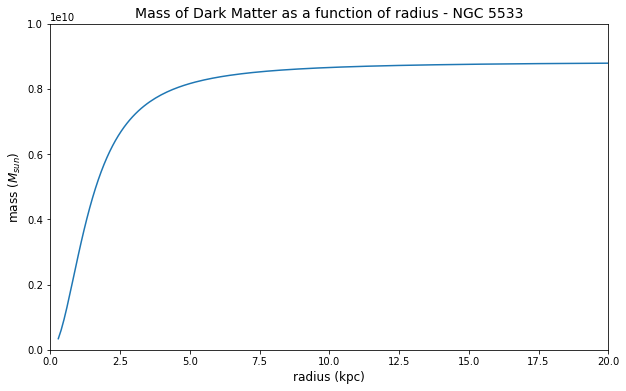

In [8]:
# Plot to visualize the mass distribution in the NGC 5533 galaxy for radii between 0 and 20 kpc
r = np.linspace(np.min(r_dat),np.max(r_dat),1000)
plt.figure(figsize=(10,6))                                                
plt.plot(r,mass_function(r,best_rc,best_rho0)) 
plt.xlabel('radius (kpc)',size=12)                                       
plt.ylabel('mass ($M_{sun}$)',size=12)                                   
plt.title(str('Mass of Dark Matter as a function of radius - NGC 5533'), size=14) 
plt.xlim(0,20)
plt.ylim(0,1e10)                                        
plt.show() 

Integrate to calculate the total mass enclosed.

>__Total mass enclosed__: <br>
    \begin{equation}
    M_{total} = \int_{0}^{r} M(r) dr
    \end{equation}

In [9]:
# Integrate to calculate total mass enclosed 
TotalMass = lambda rc,rho0: si.quad(mass_function, 0, np.max(r_dat), args=(rc,rho0))[0]

# Print total mass of Dark Matter in NGC 5533
print("The total mass of Dark Matter in the galaxy NGC 5533 is about {:.3e} solar masses.".format(TotalMass(best_rc,best_rho0)))

The total mass of Dark Matter in the galaxy NGC 5533 is about 8.864e+11 solar masses.


### Define plotting function and sliders for interactive widget

The interactive widget has two adjustable sliders where you can change the radius and the mass density of the halo. All other parameters are fixed to focus on the dark matter componet only. The next two cells of code define functions related to the widget, but do not generate the widget itself.

In [10]:
# Plotting function
def f(rc,rho0):
        
    # Define radius
    r = np.linspace(np.min(r_dat),np.max(r_dat),1000)
    
    # Plot
    plt.figure(figsize=(11,7))
    plt.xlim(0,np.max(r_dat)+0.2)
    plt.ylim(0,np.max(v_dat)+100)
    
    plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')     # Measured data points
    plt.plot(r,blackhole(r,best_Mbh),label=("Central Supermassive Black Hole"),color='black') # Black hole component
    plt.plot(r,bulge(r,best_bpref),label=("Bulge"),color='orange')       # Bulge component
    plt.plot(r,disk(r,best_dpref),label=("Disk"),color='purple')         # Disk component 
    plt.plot(r,gas(r,best_gpref),label=("Gas"),color='blue')             # Gas component
    plt.plot(r,halo(r,rc,rho0),label=("Halo"),color='green')        # Dark matter halo component
    plt.plot(r,total_all(r,best_Mbh,best_bpref,best_dpref,best_gpref,rc,rho0),label=("Total Curve"),color='red')    # Total velocity with dark matter
    plt.plot(r,total_bary(r,best_Mbh,best_bpref,best_dpref,best_gpref),label=("Luminous Matter"),linestyle='--')    # Total velocity without dark matter
    plt.fill_between(r,galdata.NGC5533['n_band_btm'](r),galdata.NGC5533['n_band_top'](r),color='#dddddd',label="Confidence Band")    # Confidence band
    plt.title("Interactive Rotation Curve - Galaxy: NGC 5533",fontsize=20)
    plt.xlabel("Radius (kpc)")
    plt.ylabel("Velocity (km/s)")
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")              # Put legend outside of the plot
    
    # Chi squared and reduced chi squared
    # Residuals
    residuals = v_dat - total_all(r_dat,best_Mbh,best_bpref,best_dpref,best_gpref,rc,rho0)
    # Error
    error = np.sqrt(v_err1**2 + galdata.NGC5533['n_v_bandwidth']**2)
    # Chi squared
    chisquared = np.sum(residuals**2/error**2)
    # Degrees of freedom
    dof = len(r_dat) - 6                 # number of degrees of freedom = number of observed data - number of fitting parameters
    # Reduced chi squared
    reducedchisquared = chisquared / dof 
    
    # Annotation
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(82,373,r"$\chi^2$: {:.5f}".format(chisquared)+'\n'+r"Reduced $\chi^2$: {:.5f}".format(reducedchisquared),bbox=props,size=10)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(69.5,350,r"Total Dark Matter Mass: {:.2e} $M_\odot$".format(TotalMass(rc,rho0)),bbox=props,size=10)
    plt.annotate('Data source: E. Noordermeer. The rotation curves of flattened Sérsic bulges. MNRAS,385(3):1359–1364, Apr 2008',
            xy=(0, 0), xytext=(0,5),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            size=10, ha='left', va='bottom')
    
    plt.show()

In [11]:
# Appearance of widget
style = {'description_width': 'initial'}
layout = {'width':'600px'}

# Sliders for the widget
rc = FloatSlider(min=0.1, max=5, step=0.1, 
                    value=best_rc, 
                    description='Halo Core Radius [kpc]', 
                    readout_format='.2f', 
                    orientation='horizontal', 
                    style=style, layout=layout)
rho0 = FloatSlider(min=0, max=1e9, step=1e7, 
                    value=best_rho0, 
                    description=r'Halo Central Mass Density [$M_{\odot} / kpc^3$]', 
                    readout_format='.2e', 
                    orientation='horizontal', 
                    style=style, layout=layout)

# Interactive widget
def interactive_plot(f):
    interact = interactive(f,
                           rc = rc,
                           rho0 = rho0,
                           continuous_update=False)
    return interact

# Button to revert back to Best Fit
button = Button(
    description="Best Fit",
    button_style='warning',
    icon='check')
out = Output()

def on_button_clicked(_):
    rc.value = best_rc
    rho0.value = best_rho0
button.on_click(on_button_clicked)

### What do rotation curves look like with and without Dark Matter?

In this activity, you can visualize how important Dark Matter is to accurately describe observed data (marked in blue points with error bars below). <br>
How much Dark Matter is in a given galaxy to account for our observations?

<div class="alert-info">Activity 1)</div>

>Use the sliders below to modify the halo parameters and investigate how incorporating a Dark Matter component allows us to more accurately match our observations. In order to determine if a model is a good fit to observed data, we use a statistic called reduced $\chi^2$. A reduced $\chi^2$ close to 1 is generally considered a good fit. A reduced $\chi^2$ far higher than 1 is not a good fit. And a reduced $\chi^2$ which is a lot lower than 1 suggests a poor theoretical model (that is, the model probably doesn't accurately describe the real universe or it is simply connecting the measured data points). As you adjust the sliders, what happens to the total rotation curve (in red) as reduced $\chi^2$ approaches 1?

In [12]:
#NBVAL_IGNORE_OUTPUT
#Because the figure doesn't save to the repository correctly.
# Widget
VBox([button,out,interactive_plot(f)])

### Slider key

>Central mass density ($\rho_0$): The central mass density is the density at the center of the galaxy, changing this value changes the magnitude of the Dark Matter curve.<br>
>Core radius ($r_c$): The core radius (also called "cutoff radius" or "scale radius") indicates where the density falls off by a factor of e (~2.7). Adjusting this factor changes where the "bump" of the curve is located.

>$kpc$ = kiloparsec, equal to 3,260 light years, or $1.917 \times 10^{16}$ miles <br>
>$km/s$ = kilometers per second (velocity unit)<br>
>$M_{\odot}$ = solar masses (X number of masses equal to our sun), approximately equal to $1.989 \times 10^{30}$ kilograms <br>
>$M_{\odot} / kpc^3$ = solar masses per kiloparsec cubed (density unit = mass/volume) <br>

### References: 

>Carroll, B. W., &amp; Ostlie, D. A. (2018). **An Introduction to Modern Astrophysics**. Cambridge University Press. <br><br>
Jimenez, Raul, Licia Verde, and S. Peng Oh. **Dark halo properties from rotation curves.** _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259. https://doi.org/10.1046/j.1365-8711.2003.06165.x. <br><br>
>Noordermeer, E., &amp; Van Der Hulst, J. M. (2007). **The stellar mass distribution in early-type disc galaxies: Surface Photometry and bulge–disc decompositions.** Monthly Notices of the Royal Astronomical Society, 376(4), 1480–1512. https://doi.org/10.1111/j.1365-2966.2007.11532.x <br><br>
>Noordermeer, E. (2008), **The rotation curves of flattened Sérsic bulges**. Monthly Notices of the Royal Astronomical Society, 385: 1359-1364. https://doi.org/10.1111/j.1365-2966.2008.12837.x <br><br>
>Taylor, John Robert. __An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.__ 2nd ed. United States of America: University Science Books, 1997. 